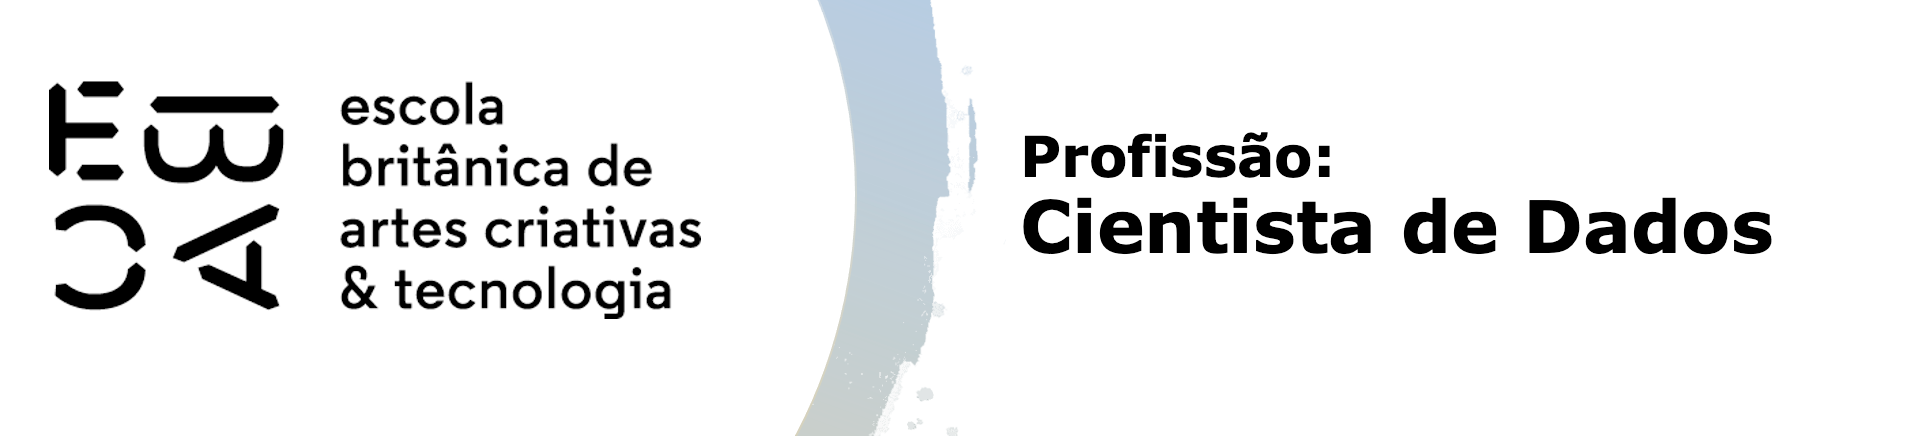

# Regressão III - Tarefa

In [36]:
# Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import patsy
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import warnings;   warnings.filterwarnings("ignore")
%matplotlib inline


In [37]:
# Carregando os dados
df = pd.read_csv('./previsao_de_renda_II.csv', index_col=0)
df.head()

index sexo posse_de_veiculo posse_de_imovel  qtd_filhos  \
data_ref                                                              
2015-01-01   5762    M                S               N           0   
2015-01-01   1279    M                S               N           0   
2015-01-01  14111    M                S               N           0   
2015-01-01   8189    M                N               S           2   
2015-01-01   1830    F                N               S           2   

             tipo_renda             educacao estado_civil tipo_residencia  \
data_ref                                                                    
2015-01-01   Empresário    Superior completo       Casado            Casa   
2015-01-01  Assalariado  Superior incompleto       Casado            Casa   
2015-01-01  Assalariado    Superior completo       Casado            Casa   
2015-01-01  Assalariado                Médio       Casado            Casa   
2015-01-01  Assalariado    Superior completo       Casado            Casa   

            idade  tempo_emprego  qt_pessoas_residencia     renda  
data_ref                                                           
2015-01-01     47      16.717808                    2.0  11138.14  
2015-01-01     30       9.600000                    2.0   2424.81  
2015-01-01     28       8.208219                    2.0  13749.66  
2015-01-01     44       1.301370                    4.0   2361.84  
2015-01-01     33       1.254795                    4.0    790.78

## 1. Avalie valores missing e substitua pela média

Neste exercício não vamos nos preocupar com valores *missing*. Substitua-os pela média.

In [38]:
# Avaliando valores missing
print(df.isnull().sum())

index                        0
sexo                         0
posse_de_veiculo             0
posse_de_imovel              0
qtd_filhos                   0
tipo_renda                   0
educacao                     0
estado_civil                 0
tipo_residencia              0
idade                        0
tempo_emprego            63760
qt_pessoas_residencia        0
renda                        1
dtype: int64


In [39]:
# Substituindo valores missing pela média
df['tempo_emprego'].fillna(df['tempo_emprego'].mean(), inplace=True)
df['renda'].fillna(df['renda'].mean(), inplace=True)

# Verificando se ainda existem valores missing
print(df.isnull().sum())


index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
dtype: int64


### 1.1 Base de testes

Separe os três últimos meses como base *holdout* (base de teste).

In [41]:
# Certificando que o DataFrame é do tipo DateTime
df.index = pd.to_datetime(df.index)

In [42]:
# Criando a base de teste
data_inicio = df.index.max() - pd.DateOffset(months=3)
base_teste = df[df.index > data_inicio]


In [43]:
# Criando a base de treinamento
base_treinamento = df[df.index <= data_inicio]


### 1.2 Primeiro modelo
 Não use *index* e não use a data. Avalie o modelo com o $R^2-ajustado$

In [45]:
# Definindo a fórmula para o modelo
formula = '''np.log(renda) ~ C(sexo)
            + C(posse_de_veiculo)
            + C(posse_de_imovel)
            + qtd_filhos
            + C(tipo_renda)
            + C(educacao, Treatment(2))
            + C(estado_civil)
            + C(tipo_residencia, Treatment(1))
            + idade
            + tempo_emprego
            + qt_pessoas_residencia
            + 1'''

# Criando as matrizes de design
Y, X = patsy.dmatrices(formula, base_treinamento)

# Ajustando o modelo
modelo = sm.OLS(Y, X)
resultado = modelo.fit()

# Imprimindo o resumo do modelo
print(resultado.summary())



                            OLS Regression Results                            
Dep. Variable:          np.log(renda)   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                     9006.
Date:                Thu, 16 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:31:03   Log-Likelihood:            -3.2006e+05
No. Observations:              250000   AIC:                         6.402e+05
Df Residuals:                  249975   BIC:                         6.404e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

#### Análise sobre os coeficientes do modelo: <br>

O modelo de regressão linear ajustado tem um R² de 0.464 e um R² ajustado de 0.464. Isso significa que o modelo explica cerca de 46.4% da variabilidade nos dados de treinamento.

<br>

- O coeficiente para `C(sexo)[T.M]` é 0.1396, o que sugere, que, mantendo todas as outras variáveis constantes, ser do sexo masculino está associado a um aumento de 13.96% no logaritmo natural da renda em comparação com ser do sexo feminino.
- O coeficiente para `C(posse_de_veiculo)[T.S]` é -0.0008, o que sugere que a posse de um veículo não tem um efeito significativo na renda.
- O coeficiente para `C(posse_de_imovel)[T.S]` é 0.1847, o que sugere que a posse de um imóvel está associada a um aumento de 18.47% no logaritmo natural da renda.
- O coeficiente para `qtd_filhos` é -0.1333, o que sugere que cada filho adicional está associado a uma diminuição de 13.33% no logaritmo natural da renda.
- O coeficiente para `idade` é 0.0050, o que sugere que cada ano adicional de idade está associado a um aumento de 0.50% no logaritmo natural da renda.
- O coeficiente para `tempo_emprego` é 0.1284, o que sugere que cada ano adicional de emprego está associado a um aumento de 12.84% no logaritmo natural da renda.


### Análise de perfil

Categorize a variável ```tempo_emprego``` em 20 quantis (cada categoria deve ter aproximadamente a mesma quantidade de observações) e faça uma tabela de perfil (armazene como dataframe) para esta categorização:

- Cada linha é uma categoria
- Uma coluna para a quantidade de observações de cada categoria
- Uma coluna para a média do log-renda para cada categoria
- Uma coluna para a média do tempo de emprego para cada categoria

Faça um gráfico da média do tempo de emprego pela média do log-renda. Insira uma célula de texto e comente se te parece que alguma das transformações vistas no módulo deve fornecer bons resultados.

In [51]:
# Categorizando a variável 'tempo_emprego' em 20 quantis e lidando com valores duplicados
base_teste['tempo_emprego_cat'], quebras = pd.qcut(base_teste.tempo_emprego, 20, duplicates='drop', retbins=True)


<ipython-input-51-cb0f4daff0ee>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_teste['tempo_emprego_cat'], quebras = pd.qcut(base_teste.tempo_emprego, 20, duplicates='drop', retbins=True)


In [54]:
# Criando a tabela de perfil
perfil = base_teste.groupby('tempo_emprego_cat').agg({'tempo_emprego': ['count', 'mean'], 'renda': lambda x: np.mean(np.log(x))}).reset_index()
perfil.columns = ['Categoria', 'Quantidade', 'Média_tempo_emprego', 'Média_log_renda']

# Exibindo a tabela de perfil
perfil


Categoria  Quantidade  Média_tempo_emprego  \
0   (0.11699999999999999, 0.827]        6526             0.517531   
1                 (0.827, 1.468]        6437             1.134042   
2                 (1.468, 2.129]        6513             1.804582   
3                 (2.129, 2.962]        6477             2.557048   
4                 (2.962, 3.682]        6497             3.332814   
5                 (3.682, 4.337]        6430             4.017205   
6                 (4.337, 4.964]        6580             4.644698   
7                 (4.964, 5.764]        6411             5.396597   
8                  (5.764, 6.63]        6429             6.223941   
9                  (6.63, 7.512]        6466             7.026592   
10                (7.512, 7.767]       23744             7.754956   
11                (7.767, 8.066]        2211             7.919534   
12                (8.066, 9.052]        6459             8.559587   
13               (9.052, 10.427]        6434             9.715651   
14              (10.427, 12.532]        6498            11.404802   
15              (12.532, 15.219]        6497            13.920586   
16              (15.219, 20.234]        6430            17.526032   
17              (20.234, 42.907]        6476            26.483367   

    Média_log_renda  
0          9.051311  
1          9.148441  
2          9.270842  
3          9.341547  
4          9.444802  
5          9.565908  
6          9.575369  
7          9.746686  
8          9.826067  
9          9.925828  
10         9.742542  
11        10.032254  
12        10.131067  
13        10.286370  
14        10.469999  
15        10.822042  
16        11.351629  
17        12.424907

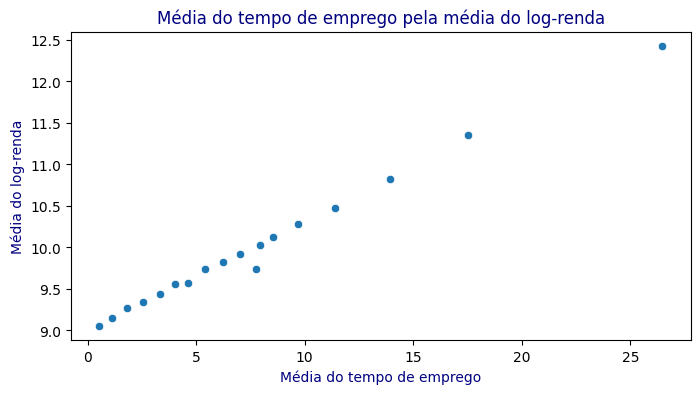

In [63]:
# Criando o gráfico de dispersão
plt.figure(figsize=(8, 4))
sns.scatterplot(x='Média_tempo_emprego', y='Média_log_renda', data=perfil)
plt.title('Média do tempo de emprego pela média do log-renda', color = 'navy')
plt.xlabel('Média do tempo de emprego', color = 'navy')
plt.ylabel('Média do log-renda', color = 'navy')
plt.show()


### Linearização

Experimente pelo menos duas técnicas de linearização vistas ao longo do módulo para melhorar o ajuste da variável ```tempo_emprego```. Compare o $R^2-ajustado$ e avalie se alguma delas apresentou resultados relevantes com relação ao primeiro modelo.


In [68]:
# Aplicando a transformação logarítmica
base_teste['log_tempo_emprego'] = np.log(base_teste['tempo_emprego'] + 1)

# Definindo a fórmula para o modelo com a transformação logarítmica
formula_log = '''np.log(renda) ~ C(sexo)
            + C(posse_de_veiculo)
            + C(posse_de_imovel)
            + qtd_filhos
            + C(tipo_renda)
            + C(educacao, Treatment(2))
            + C(estado_civil)
            + C(tipo_residencia, Treatment(1))
            + idade
            + log_tempo_emprego
            + qt_pessoas_residencia
            + 1'''

# Ajustando o modelo com a transformação logarítmica
Y_log, X_log = patsy.dmatrices(formula_log, base_teste)
modelo_log = sm.OLS(Y_log, X_log)
resultado_log = modelo_log.fit()
print(resultado_log.summary())


                            OLS Regression Results                            
Dep. Variable:          np.log(renda)   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     4847.
Date:                Thu, 16 Nov 2023   Prob (F-statistic):               0.00
Time:                        17:04:54   Log-Likelihood:            -1.5239e+05
No. Observations:              129515   AIC:                         3.048e+05
Df Residuals:                  129490   BIC:                         3.051e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

O modelo de regressão linear ajustado com **a transformação logarítmica** na variável tempo_emprego tem um R² de 0.473 e um R² ajustado de 0.473. Isso significa que o modelo explica cerca de **47.3% da variabilidade** nos dados de treinamento, o que é uma melhoria em relação ao primeiro modelo que tinha um R² ajustado de 0.464.

Observações sobre os coeficientes do modelo:

- O coeficiente para log_tempo_emprego é 1.0056, o que sugere que, mantendo todas as outras variáveis constantes, um aumento de 1% no logaritmo do tempo de emprego está associado a um aumento de aproximadamente 1.0056% no logaritmo da renda. Isso indica que a transformação logarítmica pode ter ajudado a linearizar a relação entre tempo_emprego e renda.

- Os coeficientes para as outras variáveis também mudaram em relação ao primeiro modelo, o que é esperado, pois a inclusão da transformação logarítmica de tempo_emprego pode ter alterado a relação dessas variáveis com renda.

In [69]:
# Aplicando a transformação de raiz quadrada
base_teste['sqrt_tempo_emprego'] = np.sqrt(base_teste['tempo_emprego'])

# Definindo a fórmula para o modelo com a transformação de raiz quadrada
formula_sqrt = '''np.log(renda) ~ C(sexo)
            + C(posse_de_veiculo)
            + C(posse_de_imovel)
            + qtd_filhos
            + C(tipo_renda)
            + C(educacao, Treatment(2))
            + C(estado_civil)
            + C(tipo_residencia, Treatment(1))
            + idade
            + sqrt_tempo_emprego
            + qt_pessoas_residencia
            + 1'''

# Ajustando o modelo com a transformação de raiz quadrada
Y_sqrt, X_sqrt = patsy.dmatrices(formula_sqrt, base_teste)
modelo_sqrt = sm.OLS(Y_sqrt, X_sqrt)
resultado_sqrt = modelo_sqrt.fit()
print(resultado_sqrt.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(renda)   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     6059.
Date:                Thu, 16 Nov 2023   Prob (F-statistic):               0.00
Time:                        17:05:12   Log-Likelihood:            -1.4516e+05
No. Observations:              129515   AIC:                         2.904e+05
Df Residuals:                  129490   BIC:                         2.906e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

O modelo de **regressão linear ajustado com a transformação de raiz quadrada na** variável tempo_emprego tem um R² de 0.529 e um R² ajustado de 0.529. Isso significa que o modelo explica cerca de 52.9% da variabilidade nos dados de treinamento.

Observações sobre os coeficientes do modelo:

- O coeficiente para sqrt_tempo_emprego é 0.7307, o que sugere que, mantendo todas as outras variáveis constantes, um aumento de 1 unidade na raiz quadrada do tempo de emprego está associado a um aumento de aproximadamente 73.07% no logaritmo da renda. Isso indica que a transformação de raiz quadrada pode ter ajudado a linearizar a relação entre tempo_emprego e renda.

- Os coeficientes para as outras variáveis também mudaram em relação ao primeiro modelo e ao modelo com a transformação logarítmica, o que é esperado, pois a inclusão da transformação de raiz quadrada de tempo_emprego pode ter alterado a relação dessas variáveis com renda.

### Avaliando o modelo

Avalie os resultados dos modelos construidos na base de testes.

Os resultados mostram que o R² ajustado para o modelo com transformação logarítmica é de aproximadamente 0.473, enquanto o R² ajustado para o modelo com transformação de raiz quadrada é de aproximadamente 0.529.

> Isso indica que ambos os modelos são capazes de explicar uma quantidade significativa da variabilidade nos dados de teste. No entanto, ***o modelo com a transformação de raiz quadrada fornece um ajuste ligeiramente melhor aos dados de teste***, já que seu R² ajustado é maior.

Esses resultados sugerem que a transformação de raiz quadrada pode ter ajudado a linearizar a relação entre `tempo_emprego` e `renda`, resultando em um modelo que se ajusta melhor aos dados.